# Load python environment

In [21]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from datetime import timedelta

import matplotlib.pyplot as plt

# Set parameter values

In [22]:
days_before=364

# Import booking data

In [23]:
Data=pd.read_csv('SCNTXL_data_from_jan_18_Dec_19 - Copy.csv',sep=';')
Data=Data.loc[(Data['ticket sales date']!='#')&(Data['Calendar day']!='#'),:]
Data.loc[:,'ticket sales date']=Data['ticket sales date'].apply(lambda x: pd.to_datetime(x,format='%d/%m/%Y'))
Data.loc[:,'Calendar day']=Data['Calendar day'].apply(lambda x: pd.to_datetime(x,format='%d/%m/%Y'))
Data=Data[['Calendar day','ticket sales date','PAX Softec']]
Data['PAX Softec']=Data['PAX Softec'].apply(lambda x: int(x.split(' ')[0]))

# Add full date grid

In [24]:
Ddate=[pd.to_datetime(x) for x in Data['Calendar day'].unique().tolist()]

time_before_Ddate=[]
Ddate_list=[]

for i in Ddate:
    Ddate_list=Ddate_list+[i]*(days_before+1)
    time_before_Ddate=time_before_Ddate+pd.date_range(start=i-timedelta(days=days_before),end=i,freq='D').tolist()

Data_add=DataFrame([Ddate_list,time_before_Ddate,[0]*len(Ddate_list)]).transpose()
Data_add.columns=Data.columns

Data=pd.concat([Data,Data_add])

Data=Data.drop_duplicates(subset=['Calendar day','ticket sales date'])

Data=Data.sort_values(by=['Calendar day','ticket sales date'])
Data.index=range(Data.shape[0])

# Eliminate outliers 

Outliers are defined as
1. negative difference between calendar day and ticket sales date
2. difference between calendar day and ticket sales date > 500

In [25]:
Data['Time']=(Data['Calendar day']-Data['ticket sales date']).apply(lambda x: int(x.days))
Data=Data.loc[(Data['Time']>=0)&(Data['Time']<=days_before),:]
Data=Data[['Calendar day','Time','PAX Softec']]

# Create booking curves

In [26]:
Data['Time']=-Data['Time']
Data=Data.set_index(['Calendar day','Time'])
BookingCurves=Data.groupby(level=[0,1]).sum().groupby(level=[0]).cumsum().reset_index()
BookingCurves['Time']=-BookingCurves['Time']

# Graphical analysis

Text(0, 0.5, 'Bookings')

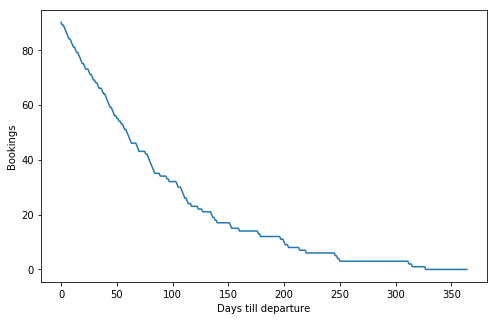

In [27]:
pick_date=BookingCurves['Calendar day'].unique()[265]

plt.figure(1, figsize=(8, 5))

plt.plot(BookingCurves.loc[BookingCurves['Calendar day']==pick_date,'Time'],
BookingCurves.loc[BookingCurves['Calendar day']==pick_date,'PAX Softec'])

plt.xlabel('Days till departure')
plt.ylabel('Bookings')

In [28]:
BookingCurves_Mean=BookingCurves.groupby('Time')['PAX Softec'].mean().reset_index()

In [29]:
BookingCurves_Mean=BookingCurves_Mean.rename(columns={'PAX Softec': 'PAX Softec Avg'})

Text(0, 0.5, 'Bookings')

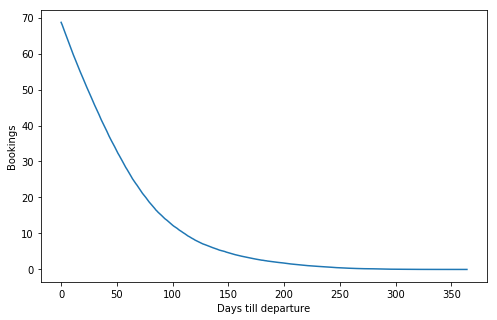

In [30]:
plt.figure(1,figsize=(8,5))

plt.plot(BookingCurves_Mean['Time'],BookingCurves_Mean['PAX Softec Avg'])

plt.xlabel('Days till departure')
plt.ylabel('Bookings')

In [31]:
BookingCurves=BookingCurves.merge(BookingCurves_Mean,on='Time')

In [32]:
BookingCurves['Error']=BookingCurves['PAX Softec']-BookingCurves['PAX Softec Avg']

In [33]:
BookingCurves['Std']=BookingCurves.groupby('Time')['Error'].transform(lambda x: np.sqrt(np.mean(x**2)))

Text(0, 0.5, 'Bookings')

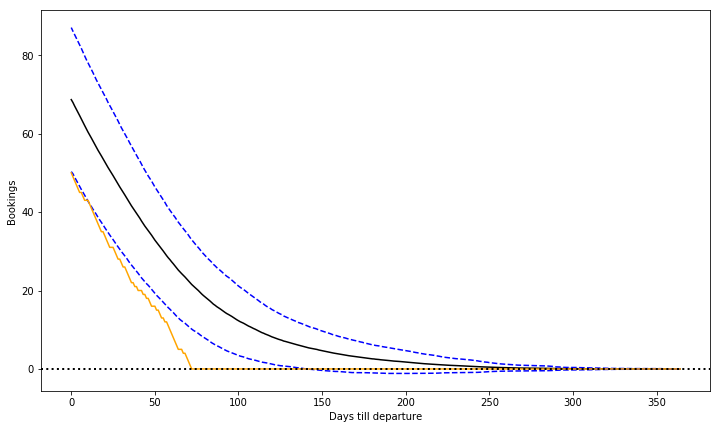

In [34]:
conf_level=1

pick_date=BookingCurves['Calendar day'].unique()[1]

plt.figure(1,figsize=(12,7))

plt.plot(BookingCurves.drop_duplicates(subset=['Time'])['Time'],
BookingCurves.drop_duplicates(subset=['Time'])['PAX Softec Avg'],color='black')

plt.plot(BookingCurves.drop_duplicates(subset=['Time'])['Time'],
BookingCurves.drop_duplicates(subset=['Time'])['PAX Softec Avg']\
+conf_level*BookingCurves.drop_duplicates(subset=['Time'])['Std'],color='blue',linestyle='--')

plt.plot(BookingCurves.drop_duplicates(subset=['Time'])['Time'],
BookingCurves.drop_duplicates(subset=['Time'])['PAX Softec Avg']\
-conf_level*BookingCurves.drop_duplicates(subset=['Time'])['Std'],color='blue',linestyle='--')

plt.plot(BookingCurves.loc[BookingCurves['Calendar day']==pick_date,'Time'],
BookingCurves.loc[BookingCurves['Calendar day']==pick_date,'PAX Softec'],color='orange')

plt.axhline(linewidth=2,color='black',linestyle=':')

plt.xlabel('Days till departure')
plt.ylabel('Bookings')